# Predicting Taxi Pickups in NYC

In today's practice, I will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, I will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

I will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, I will normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

First, I will generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis.  We will see if the pattern of taxi pickups make intuitive sense. Let us begin

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
rcParams['figure.figsize'] = 6,5
sns.set_context("poster")

In [2]:
#Let us first import our dataset
train_data = pd.read_csv('dataset_1_train.txt')
test_data = pd.read_csv('dataset_1_test.txt')

# Clean up data types
train_data["TimeMin"] = train_data["TimeMin"].apply(lambda x: x / 1440)
train_data["PickupCount"] = train_data["PickupCount"].astype(int)

test_data["TimeMin"] = test_data["TimeMin"].apply(lambda x: x / 1440)
test_data["PickupCount"] = test_data["PickupCount"].astype(int)

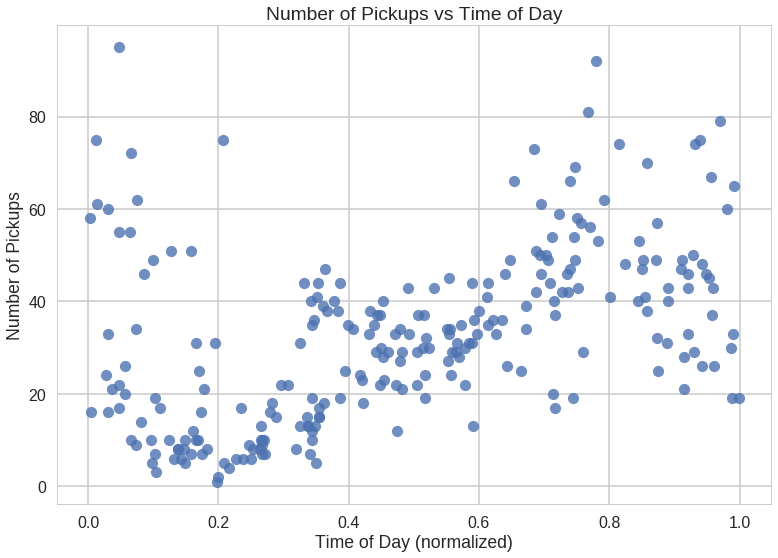

In [25]:
# Scatter plot 
fig, ax = plt.subplots(1)

sns.regplot(train_data["TimeMin"], train_data["PickupCount"], fit_reg = False)

ax.set_xlabel("Time of Day (normalized)")
ax.set_ylabel("Number of Pickups")
ax.set_title("Number of Pickups vs Time of Day")
sns.set_style('whitegrid')

The scatter plot in itself tells us little about the our data. There is a large variation between the number of pickup counts with similar times of the day. However, the general trend shows that the number of pickups rises steadily with the time of the day. Lets us explore this further for better insight

# k-Nearest Neighbors

Let us begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. I will use the sklearn's built-in functions to run k-NN regression. Create a KNeighborsRegressor object, use the fit method in the object to fit a k-NN regressor model, use the predict method to make predictions from the model, and the score method to evaluate the  R2R2  score of the model on a data set.

In [4]:
# Generate all k-NN regression models
regressors = []
kNums = [1, 2, 10, 25, 50, 100, 200]

for k in kNums:
    knnReg = KNeighborsRegressor(n_neighbors=k)
    X = [[x] for x in train_data["TimeMin"]]
    knnReg.fit(X, train_data["PickupCount"])
    regressors.append(knnReg)

## Visualize the fitted model

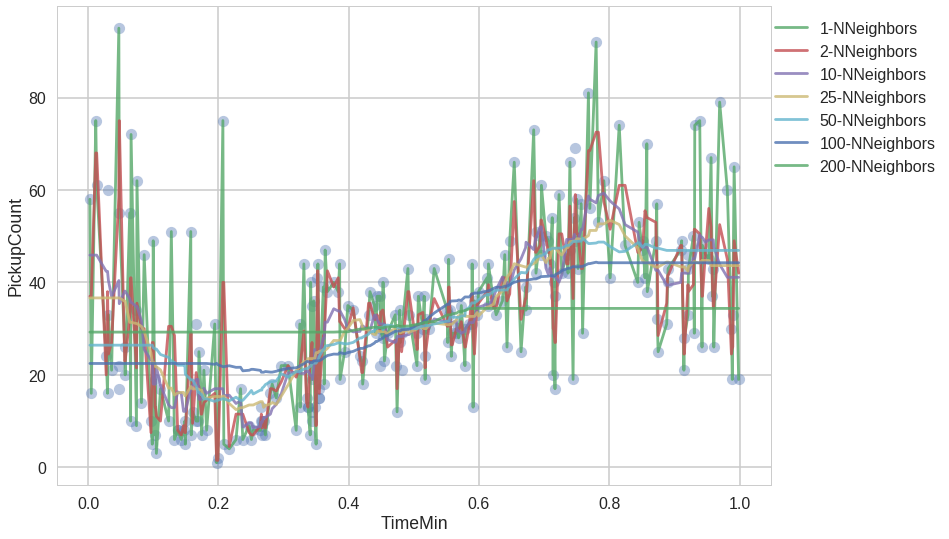

In [5]:
# Create Plot 
fig, ax = plt.subplots(1)
sns.regplot(train_data["TimeMin"], train_data["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4})

for i,k in enumerate(kNums):
    yHat = regressors[i].predict([[x] for x in train_data["TimeMin"].sort_values()])
    ax.plot(train_data["TimeMin"].sort_values(), yHat, label="{}-NNeighbors".format(kNums[i]), alpha=.8)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))

# How does $k$ affect the fitted model?

We find that for very small $k$, there is a lot of noise that is captured in the model, such as the zig-zagging behavior of the green regression line above.  However, at very large $k$, our regression takes an average of too many neighbors in our data, producing a nearly horizontal line that does not reveal the underlying structure of our data.  Values of $k$ like 50 seem to capture a sinusoidal structure of this dataset very well.  

In [6]:
# Gathering R^2 values for each model on training data
trainScores = {}

for i,reg in enumerate(regressors):
    X = [[x] for x in train_data["TimeMin"]]
    trainScores[kNums[i]] = reg.score(X, train_data["PickupCount"])
    
trainScores

{1: 0.81088890860472873,
 2: 0.64540406927447336,
 10: 0.45770521849580365,
 25: 0.41946706587498828,
 50: 0.35325229524195634,
 100: 0.28702785735864389,
 200: 0.10863100988399976}

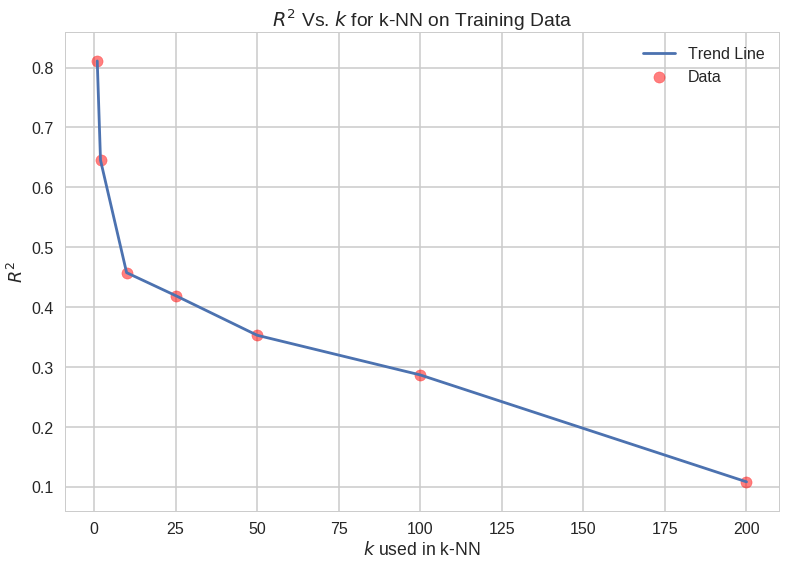

In [7]:
fig, ax = plt.subplots(1)
ax.scatter([int(key) for key in list(trainScores.keys())], [trainScores[key] for key in list(trainScores.keys())], c="red", label="Data", alpha=0.5)
ax.plot([int(key) for key in list(trainScores.keys())], [trainScores[key] for key in list(trainScores.keys())], label="Trend Line")
ax.set_title("$R^2$ Vs. $k$ for k-NN on Training Data")
ax.set_xlabel("$k$ used in k-NN")
ax.set_ylabel("$R^2$")
ax.legend()

# $R^2$ values for training data.

We find that, as expected, the $R^2$ values for our training data monotonically decrease towards 0 as $k$ grows larger.  This makes sense because $k$ being very small tries to capture almost all of the variation in the data and overfitting the data, generating a model that very closely predicts each data point, while $k$ being very large tries to look at the broader structure of the data when generating a model, implying that it less closely resembles individual variation between data points.  

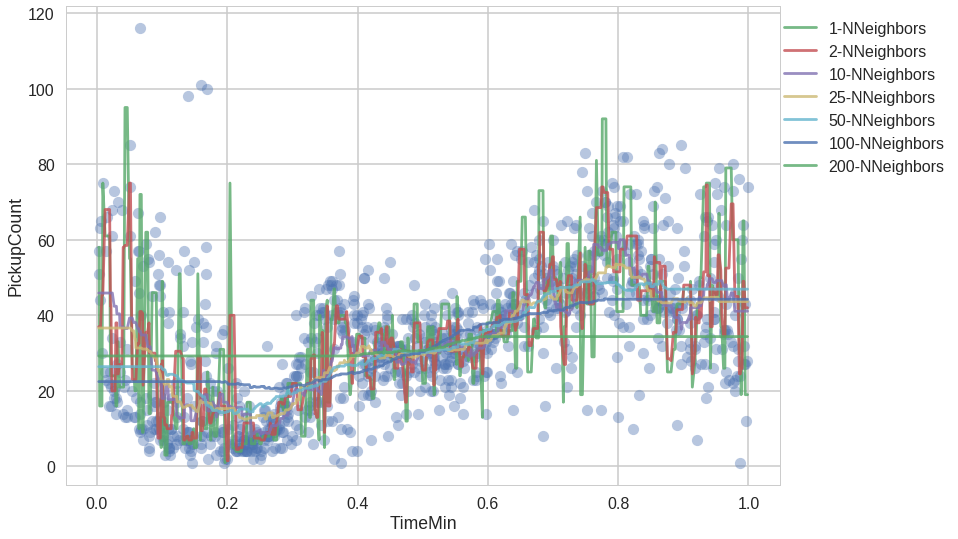

In [8]:
# Plot models on test data
# Create Plot 
fig, ax = plt.subplots(1)
sns.regplot(test_data["TimeMin"], test_data["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4})

for i,k in enumerate(kNums):
    yHat = regressors[i].predict([[x] for x in test_data["TimeMin"].sort_values()])
    ax.plot(test_data["TimeMin"].sort_values(), yHat, label="{}-NNeighbors".format(kNums[i]), alpha=.8)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))

In [9]:
# Gathering R^2 values for each model on test data
testScores = {}

for i,reg in enumerate(regressors):
    X = [[x] for x in test_data["TimeMin"]]
    testScores[kNums[i]] = reg.score(X, test_data["PickupCount"])
    
testScores

{1: -0.04560301563038216,
 2: 0.23298509885774188,
 10: 0.41724791407053397,
 25: 0.41365598420422983,
 50: 0.38047568461148934,
 100: 0.31184648633748668,
 200: 0.10953014692642915}

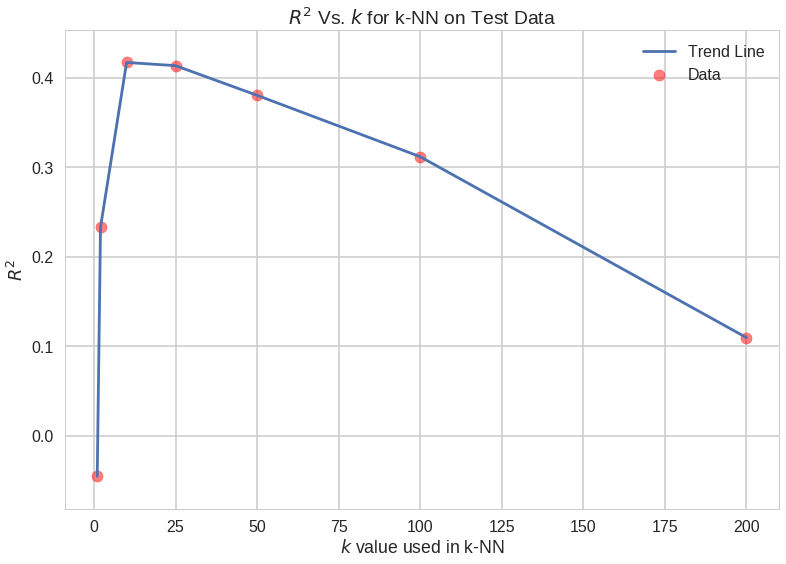

In [10]:
fig, ax = plt.subplots(1)
ax.scatter([int(key) for key in list(testScores.keys())], [testScores[key] for key in list(testScores.keys())], c="red", label="Data", alpha=0.5)
ax.plot([int(key) for key in list(testScores.keys())], [testScores[key] for key in list(testScores.keys())], label="Trend Line")
ax.set_title("$R^2$ Vs. $k$ for k-NN on Test Data")
ax.set_xlabel("$k$ value used in k-NN")
ax.set_ylabel("$R^2$")
ax.legend()

# $R^2$ values for test data.

As we can see in the above graph plotting the test data with the same k-NN regression lines from the training data, it is clear that the extreme values of $k$, both very small and very large, perform poorly compared to the mid-ranged $k$ values.  This makes sense, as very small $k$ overfits the training data and bears little resemblance to the test data (explaining why we have a negative $R^2$ value for $k = 1$, meaning that this 1-NN model is incredbily poor at predicting the training data).  In the same vein, very large $k$, such as the 200-NN model, only accurately represents a few of the center data points, failing to accurately depict many of the edge data points in our model.  Therefore, there is no surprise to see that $k = 10, 25$ both performed the best using the $R^2$ metric. 

# Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. We will see if there are advantages in using a parametric regression model over k-NN regression.

We will use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and we will use the `predict` method to make predictions. To include an intercept term in the regression model, we will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Also we will use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. Lastly we will use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions,  we will try to answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?

- Analyze residual plots:
    - We will make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

In [11]:
# Generate linear regression model

# Add constant to data
xConst = sm.add_constant(train_data["TimeMin"])
trainLinModel = sm.OLS(train_data["PickupCount"], xConst).fit()
print(trainLinModel.summary())

                            OLS Regression Results                            
Dep. Variable:            PickupCount   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     64.82
Date:                Mon, 23 Oct 2017   Prob (F-statistic):           3.43e-14
Time:                        21:33:28   Log-Likelihood:                -1060.1
No. Observations:                 250   AIC:                             2124.
Df Residuals:                     248   BIC:                             2131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0264      2.121      8.501      0.0

In [12]:
trainLinModel.params
trainLinModel.conf_int()

,0,1
const,13.849865,22.202906
TimeMin,22.879319,37.698727


## Sign of the slope

The sign of the slope is positive, indicating that, according to our model, prices rise throughout the day.

## Confidence Intervals

Since 0 is within neither of the estimations, we expect the estimates to be statistically significant.

A 99% confidence interval will be *looser* than a 95% CI since 99% of the former CI's constructed need to include the true but unknown $\beta_i$.

In [13]:
xPrime = np.arange(0, 1, 0.001)
xPrime = sm.add_constant(xPrime)
yHatPrime = trainLinModel.predict(xPrime)

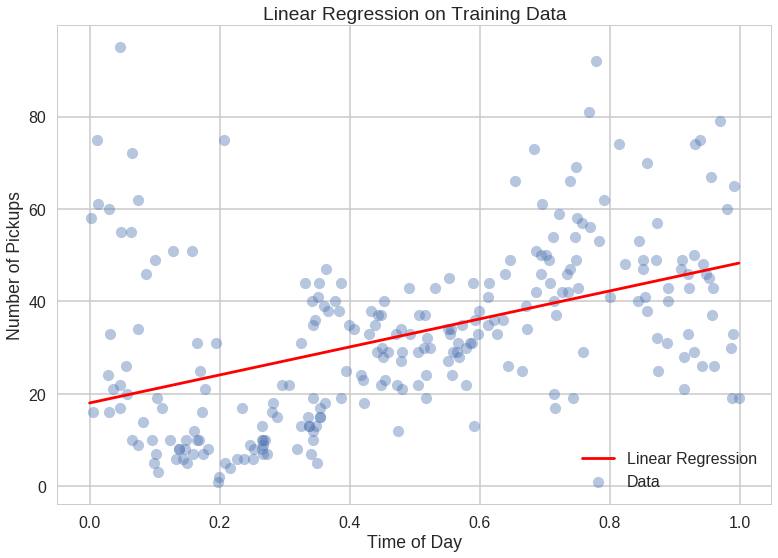

In [14]:
fig, ax = plt.subplots(1)
sns.regplot(train_data["TimeMin"], train_data["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4}, label="Data")
ax.plot(xPrime[:,1], yHatPrime, label="Linear Regression", color="red")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Number of Pickups")
ax.set_title("Linear Regression on Training Data")
ax.legend()

In [17]:
# Determine training R^2

xTrain = train_data["TimeMin"].tolist()
xTrain = sm.add_constant(xTrain)
yHatTrain = trainLinModel.predict(xTrain)
yTrain = train_data["PickupCount"].tolist()
trainScore = r2_score(yTrain, yHatTrain)

# Determine test R^2

xTest = test_data["TimeMin"].tolist()
xTest = sm.add_constant(xTest)
yHatTest = trainLinModel.predict(xTest)
yTest = test_data["PickupCount"].tolist()
testScore = r2_score(yTest, yHatTest)

print("R^2: Training {}, Test {}".format(trainScore, testScore))

R^2: Training 0.20721375209894033, Test 0.24771232994848624


We find that the $R^2$ is substantialy lower than the best ones found using kNN ($\approx 0.41$). This makes sense, given that the function that seems to underlie our distribution looks sinusoidal and thus cannot be approximated well by linear regression.

Curiously, the $R^2$ on the training set (using linear regression) is lower than the one of the test dataset. This can be a mere sampling effect given the relatively small sample size.

# Residuals

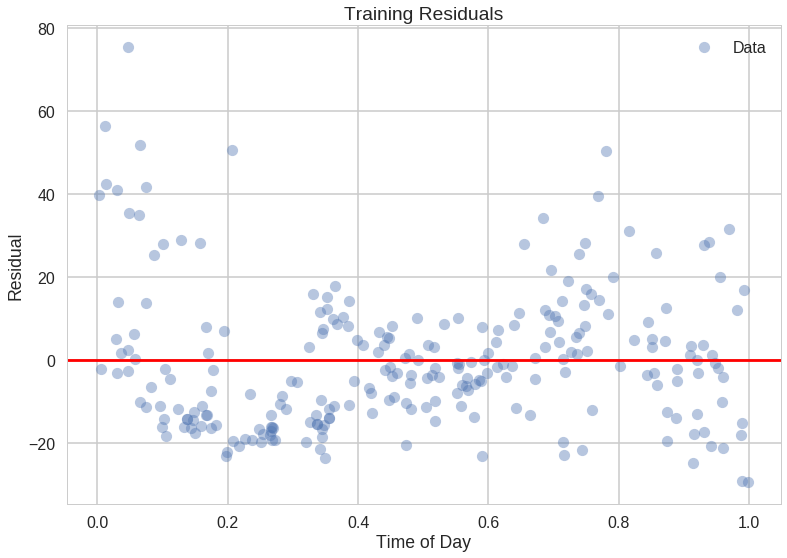

In [18]:
eTrain = yTrain - yHatTrain
fig, ax = plt.subplots(1)
sns.regplot(train_data["TimeMin"], eTrain, fit_reg = False, scatter_kws={'alpha':0.4}, label="Data")

plt.axhline(y=0, color="r")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Residual")
ax.set_title("Training Residuals")
ax.legend()

The residuals are, particularly early in the morning, not normally distributed. This violates our model's linearity assumption. A histogram of normalized residuals makes the deviation from a Gaussian even more clear:

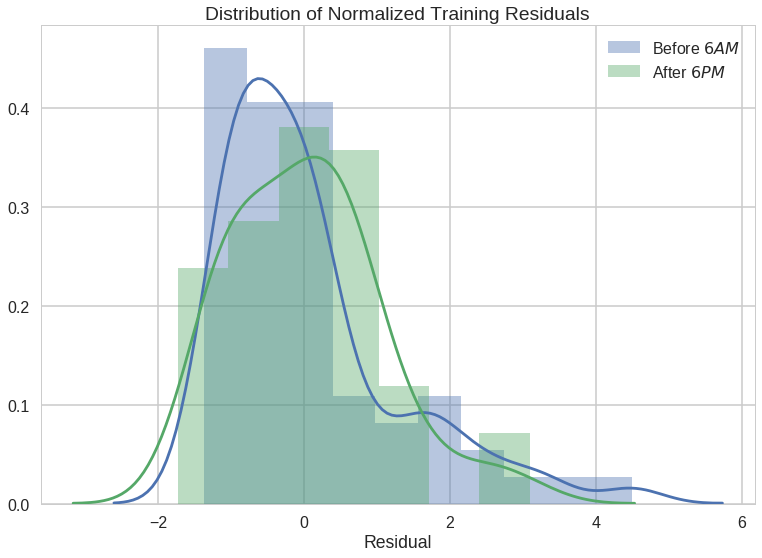

In [19]:
eTrainNormal = stats.zscore(eTrain)
fig, ax = plt.subplots(1)
sns.distplot(eTrainNormal[:63], label="Before $6 AM$")
sns.distplot(eTrainNormal[189:], label="After $6 PM$")

ax.set_xlabel("Residual")
ax.set_title("Distribution of Normalized Training Residuals")
ax.legend()

The above histogram reveals that the distribution of residuals throughout the day varies significantly, violating the assumption of normally distributed, homoskedastic noise.  The blue distribution above represents the residuals before 6 AM, and is significantly skewed to the right.  However, later in the evening, we find that the green distribution is much more symmetric.

# Polynomial Regression

We proceed to higher-order polynomial models for regression:



In [20]:
# Generate all polynomial regression models
regressors = []
degrees = [2, 3, 10, 25, 50]
xTrainPoly = []
xTestPoly = []

for i,d in enumerate(degrees):    
    genPolyTerms = PolynomialFeatures(degree=d, interaction_only=False)
    xTrainPoly.append(genPolyTerms.fit_transform(xTrain))
    xTestPoly.append(genPolyTerms.fit_transform(xTest))

    trainPolyRegressionModel = LinearRegression(fit_intercept=True)
    trainPolyRegressionModel.fit(xTrainPoly[i], yTrain)
    
    regressors.append(trainPolyRegressionModel)

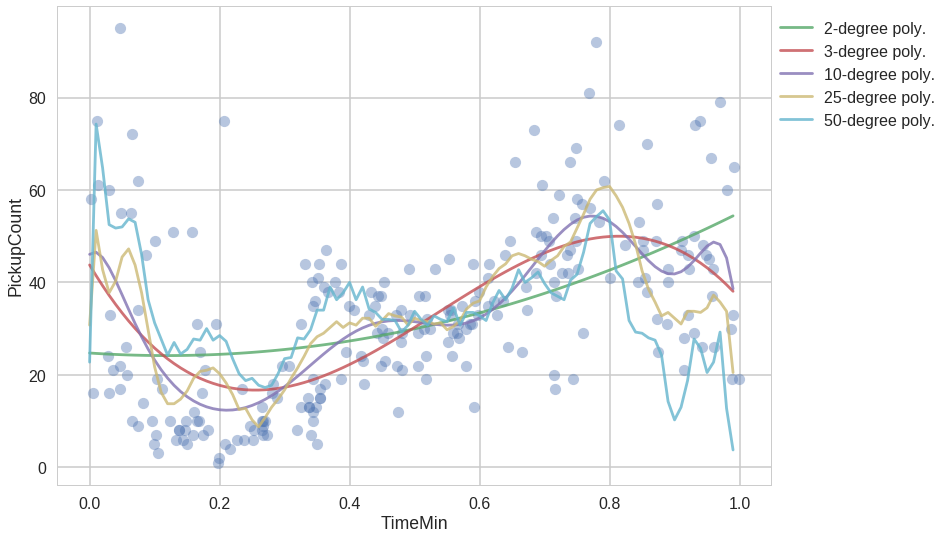

In [21]:
# Create Plot 
fig, ax = plt.subplots(1)
sns.regplot(train_data["TimeMin"], train_data["PickupCount"], fit_reg = False, scatter_kws={'alpha':0.4})

xLin = np.arange(0,1,.01)
xLin = sm.add_constant(xLin)

for i,k in enumerate(degrees):
    genPolyTerms = PolynomialFeatures(degree=k, interaction_only=False)
    yHat = regressors[i].predict(genPolyTerms.fit_transform(xLin))
    ax.plot(xLin[:,1], yHat, label="{}-degree poly.".format(degrees[i]), alpha=.8)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))

Visual Inspection – Choice of polynomial degree
Given the shape of the data, an odd degree seems appropriate. Squinting, we see one maximum and one minimum. Hence, a degree of $3$ should be sufficient.

Not normalizing our predictor to the range [0,1] would lead to high feature values for powers of $x$ (i.e. $1440^3$) and therefore very small coefficients. Normalizing predictors makes the model more readable and prevents issues of floating-point imprecision.

# $R^2$

In [22]:
# Gathering R^2 values and residual values for each model on training data
trainScores = {}
eTrain = {}

for i,k in enumerate(degrees):
    genPolyTerms = PolynomialFeatures(degree=k, interaction_only=False)
    yHatTrain = regressors[i].predict(genPolyTerms.fit_transform(xTrain))
    eTrain[k] = yTrain - yHatTrain
    trainScores[k] = r2_score(yTrain, yHatTrain)

trainScores

{2: 0.2324332710285808,
 3: 0.3748362391177078,
 10: 0.42827706862142456,
 25: 0.36864702295185803,
 50: 0.042039707826227568}

In [23]:
# Gathering R^2 values for each model on test data
testScores = {}

for i,k in enumerate(degrees):
    genPolyTerms = PolynomialFeatures(degree=k, interaction_only=False)
    yHatTest = regressors[i].predict(genPolyTerms.fit_transform(xTest))
    testScores[k] = r2_score(yTest, yHatTest)

testScores

{2: 0.25572414216191597,
 3: 0.37858436224816705,
 10: 0.40200780071309261,
 25: 0.33648380818396739,
 50: 0.0073757895809912766}

A high training $R^2$ does not necessarily indicate a high test $R^2$ values since a model could overfit the training data. This is the case with the 25-degree polynomial model for instance.

In general, we observe the best test $R^2$, as expected, with the 3-degree model ($R^2 \approx 0.39$). It is higher than the one of the linear regression model ($R^2 \approx 0.25$) and close to the 10 and 25-kNN models ($R^2 \approx 0.42$). It is impressive how well kNN works, given that it makes less assumptions about the underlying data.

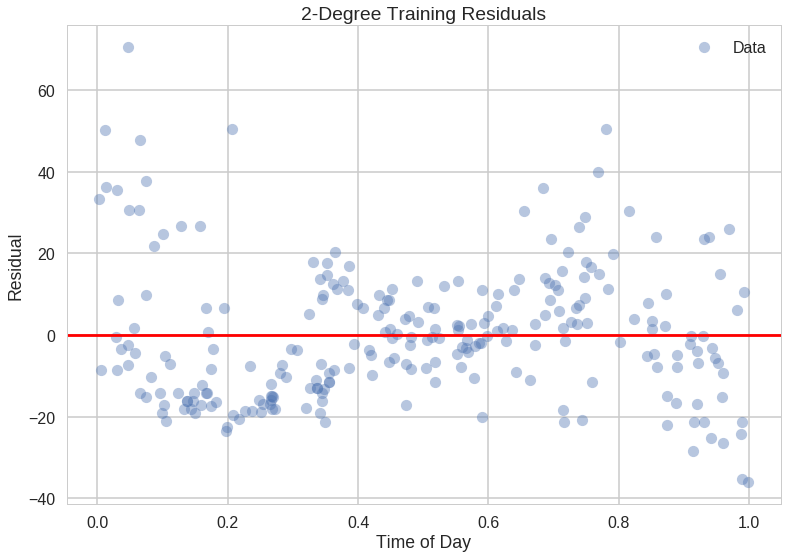

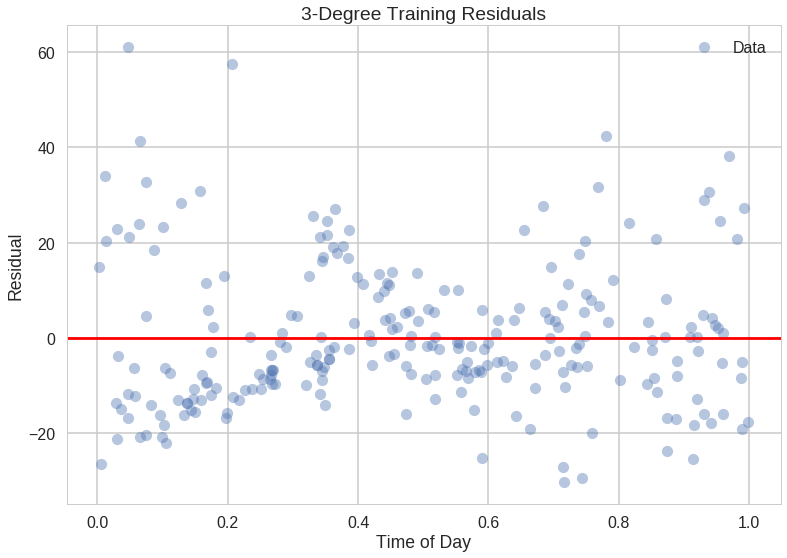

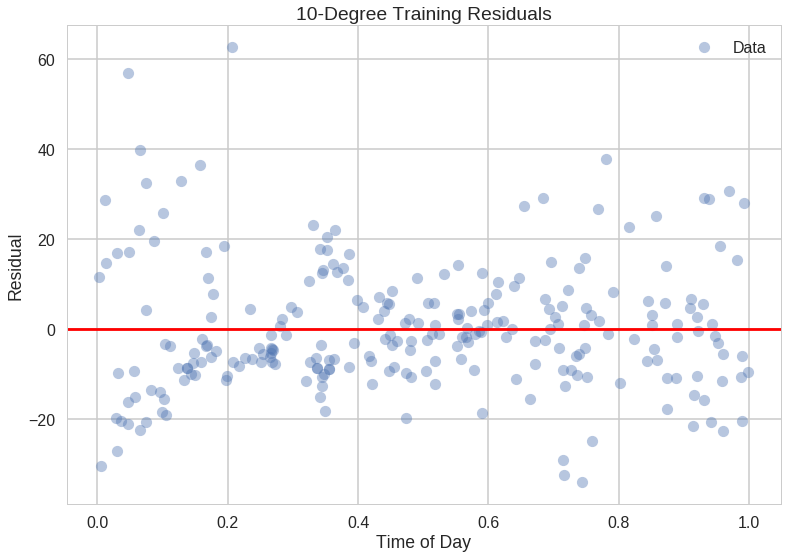

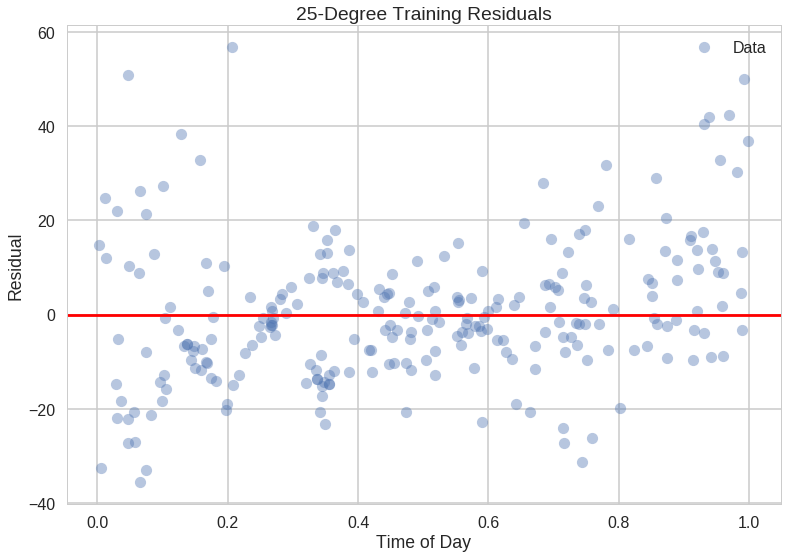

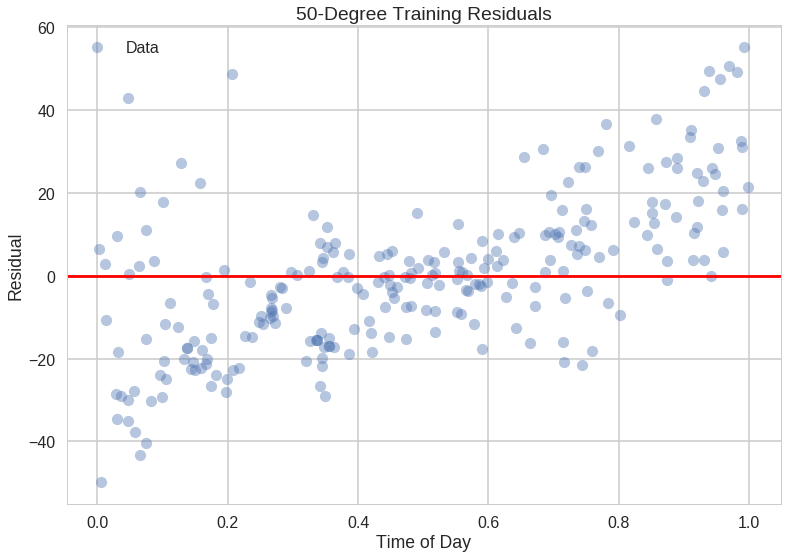

In [24]:
for degree in eTrain:
    fig, ax = plt.subplots(1)
    sns.regplot(train_data["TimeMin"], eTrain[degree], fit_reg = False, scatter_kws={'alpha':0.4}, label="Data")

    plt.axhline(y=0, color="r")
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Residual")
    ax.set_title("{}-Degree Training Residuals".format(degree))
    ax.legend()

The residual plots for the 3, 10, and 25-degree polynomials look like random blobs. Hence, the underlying assumption of normal, homoskedastic noise is fulfilled.
The 2-degree model seems to underfit, and the 50-degree model clearly does not fit the data after 7pm.

In summary, The two models that work best for predicting tax cab pick-ups are 25-kNN and the 3-degree polynomial regression. We choose 25-kNN because it makes fewer assumptions about the data than the polynomial regression and results in more precise predictions. There is something to be said about the explanatory power of the polynomial regression. In our eyes, a sinusoidal regression would probably yield the best results.

However, the 25-kNN model is by no means perfect. It suffers from unnecessarily poor predictions around $x=0$ and $x=1$ because it does not take advantage of the fact that our data is circular. This means for example that, ideally, kNN should take data points from both pre-midnight and post-midnight into account when calculating a prediction for 11:59pm. Currently that is not the case. One possible remedy would be to *pad* the data from [0,1] with copies shifted to [-1,0] and [1,2].


One last improvement in predictions could be achieved if we had access to information on whether the rides takes place on a weekday or on the weekend. Rather unusually many datapoints are to be found from 12am to 5am. We hypothesize that these are a result of nightlife on weekends. By identifying weekdays, our model would gain explanatory power.